In [52]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import image
from keras.engine.topology import Input
from keras.models import Model, load_model
from keras.applications.xception import preprocess_input

from vis.utils import utils
from keras import activations
from vis.visualization import visualize_saliency


In [25]:
plt.rcParams['figure.figsize'] = (8, 6)

IMG_SIZE = 299
img_shape = (IMG_SIZE, IMG_SIZE, 3)

# EPOCHS = 50
# BATCH_SIZE = 16
# NUM_CLASSES = 76


In [3]:
model = load_model('/Users/yueying.teng/Documents/indoor_gps/models/2018-12-19_fulldata_gps_xception_model_0.01_midway.h5')
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [48]:
classes = []
for i in np.random.randint(76, size = 5):
    classes.append('{:04d}'.format(i + 1))
    

In [56]:
img_path = []

for i in classes:
    class_dir = '/Users/yueying.teng/Documents/indoor_gps/data/test/class_' + i
    img = random.choice(os.listdir(class_dir))
    img_dir = os.path.join(class_dir, img)
    img_path.append(img_dir)
    

In [58]:
def load_img(img_dir):
    img_img = image.load_img(img_dir, target_size = (IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img_img)
    img_processed = preprocess_input(img)

    return img_processed


In [64]:
pred_label = []

for i in img_path:
    img_processed = load_img(i)
    predictions = model.predict(img_processed[np.newaxis, :])
    pred_label.append(np.argmax(predictions[0]) + 1)
    

In [66]:

# Utility to search for layer index by name.
layer_idx = utils.find_layer_idx(model, 'dense_4')
print(layer_idx)

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)


137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


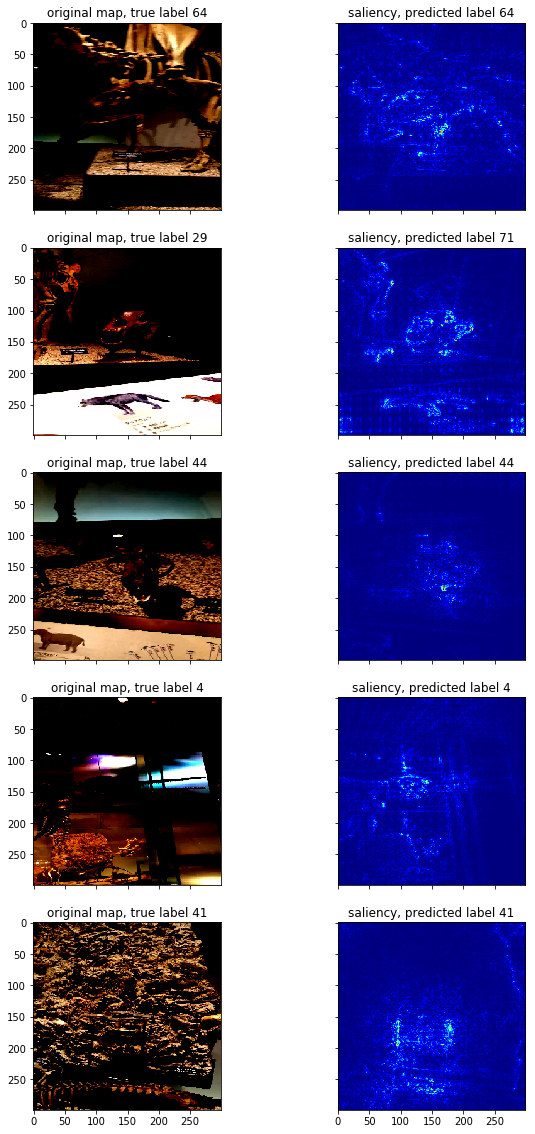

In [82]:
plt.rcParams['figure.figsize'] = (10, 20)

fig, ax = plt.subplots(5, 2, sharex='col', sharey='row')

for i in range(5):
    for j in range(2):
        
        if j == 1:
            # saliency
            grads = visualize_saliency(model, layer_idx, filter_indices = pred_label[i], 
                                       seed_input = load_img(img_path[i]), backprop_modifier = 'guided')
            # visualize grads as heatmap
            ax[i, j].imshow(grads, cmap = 'jet')
            ax[i, j].set_title('saliency, predicted label {}'.format(pred_label[i]))
        
        else:
            ax[i, j].imshow(load_img(img_path[i]))
            ax[i, j].set_title('original image, true label {}'.format(int(classes[i])))
            